# Timeseries Regression task - Project 2

## Brett Hallum, Mridul Jain, and Solomon Ndungu

The purpose of this project is to use timeseries forecasting and regression models to forecast the amount of funding needed by "Lending Club" 


In [1]:
import os
os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
os.getcwd()

'C:\\Users\\emrijai\\Documents\\IPython Notebooks\\MS7331\\Project1\\MSDS7331_Project1'

In [2]:
import pandas as pd
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

### Abstract
As we can see from the Loan amount the company has clearly providing more loans in the past few years and the amount of loans have increased considerably. Even though the cash from interest and installments is coming in, but it might still not be enough to continue the future funding needs. In order to predict how much money the company will need in the next few months is very important to plan accordingly. 
Following steps are taken below to analyze the future funding needs by "Lending Tree" to continue growing. 
1. Visualize the trends
2. Check for Non-Stationarity, and statirnarize the series data
3. Check the ACF/PACF charts to find the optimal parameters
4. Build appropriate Model (ARIMA/ARMA)
5. Forecast the amount of money required in next 100 Weeks

In [3]:
#Bring in data set
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
loan_df = pd.read_csv('LoanData/Funded_Amount_Sum.csv', parse_dates='Month', index_col='Month',date_parser=dateparse)
loan_df = loan_df.dropna()
print loan_df.info()
print loan_df.head()

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
import calendar
pd.options.mode.chained_assignment = None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2007-06-01 to 2015-12-01
Data columns (total 5 columns):
Funded_Amnt_Cum          103 non-null int64
Funded_Amnt_Monthly      103 non-null int64
Total_Rec_Payment        103 non-null int64
Total_Payment_Monthly    103 non-null int64
Difference_Amount        103 non-null int64
dtypes: int64(5)
memory usage: 4.8 KB
None
            Funded_Amnt_Cum  Funded_Amnt_Monthly  Total_Rec_Payment  \
Month                                                                 
2007-06-01            91850                91850             103711   
2007-07-01           423950               332100             452870   
2007-08-01           912550               488600             940349   
2007-09-01          1285500               372950            1318937   
2007-10-01          1968375               682875            1984635   

            Total_Payment_Monthly  Difference_Amount  
Month                                                 
2007-0

In [4]:
loan_df.index

DatetimeIndex(['2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01', '2007-12-01', '2008-01-01',
               '2008-02-01', '2008-03-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=103, freq=None)

In [5]:
loan_df_shape_old = loan_df.shape[0]

#### Monthly Amount funded by the company is shown below (prior to 2011, the funding was very less, and has only picked up in recent monhts)

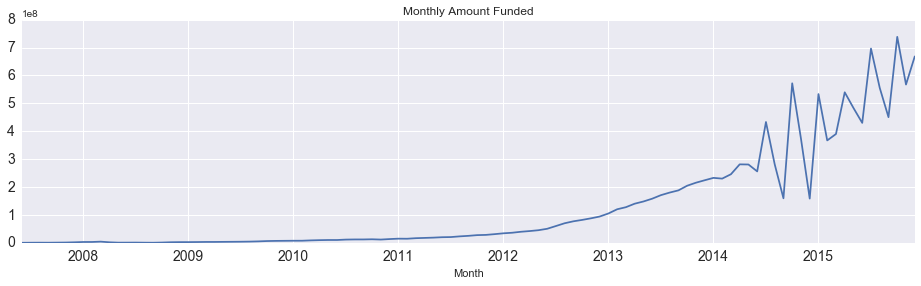

In [6]:
loan_df['Funded_Amnt_Monthly'].plot(figsize=(16,4), title= 'Monthly Amount Funded', fontsize=14)
plt.savefig('Monthly_Loaned_Amount.png', bbox_inches='tight')

The below picture shows that the amount of incoming funds from Interest and total payments has reduced considerably in the past few months specially during the end of 2015. If the data is correct, then this is alarming sign for the company, as there are a lot of loans issues and huge debt situation is looming. 

In the recent months difference between received money vs loaned money has increased very rapidly as can be seen below. Close to about 6 BUSD is currently issues to borrowers and the Inflow has reduced considerably.

In summary:
1. 12BUSD loans are issues so far
2. ~6.2 BUSD is currently issues as loans 
3. ~6.5 BUSD payments collected
4. Payments collection slope flattened and clearly the amount of money coming in has reduced considerably

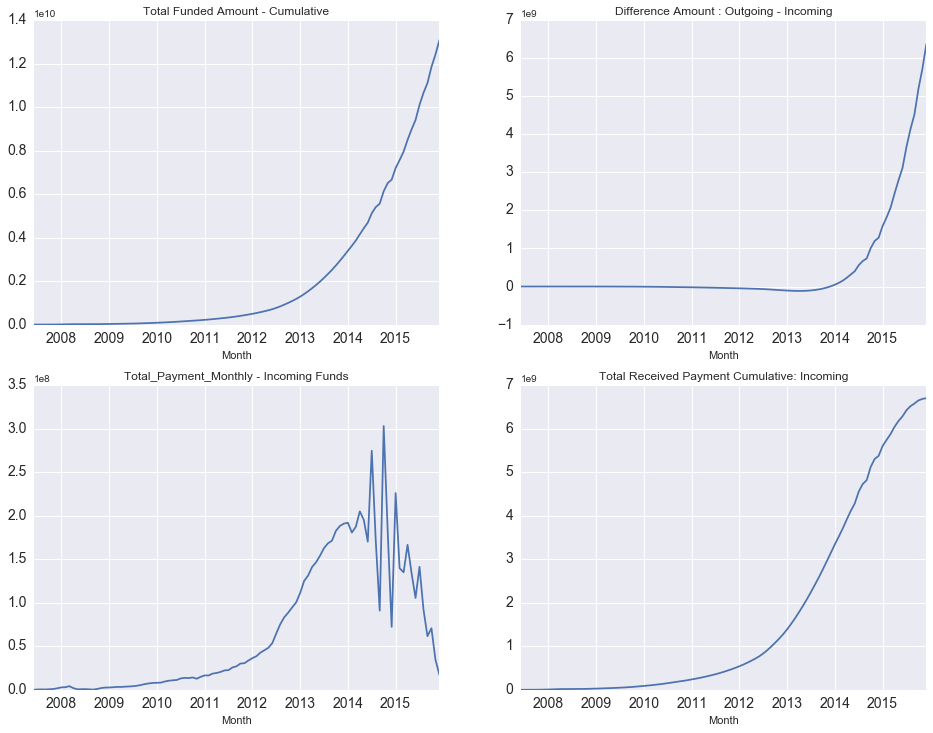

In [7]:
from matplotlib.pyplot import *
fig = plt.figure(figsize=(16,12))

subplot (2,2,1)
loan_df['Funded_Amnt_Cum'].plot(title= 'Total Funded Amount - Cumulative', fontsize=14)


subplot (2,2,2)
loan_df['Difference_Amount'].plot( title= 'Difference Amount : Outgoing - Incoming', fontsize=14)


subplot (2,2,3)
loan_df['Total_Payment_Monthly'].plot( title= 'Total_Payment_Monthly - Incoming Funds', fontsize=14)


subplot (2,2,4)
loan_df['Total_Rec_Payment'].plot( title= 'Total Received Payment Cumulative: Incoming', fontsize=14)


As we visualize the the above plot we can see there is both an upward trend (exponential) in the data and there seems to be some seasonality to it
#### Next, visualizing the data with seasonal_decompose function in statsmodel. 
The trend becomes even more obvious

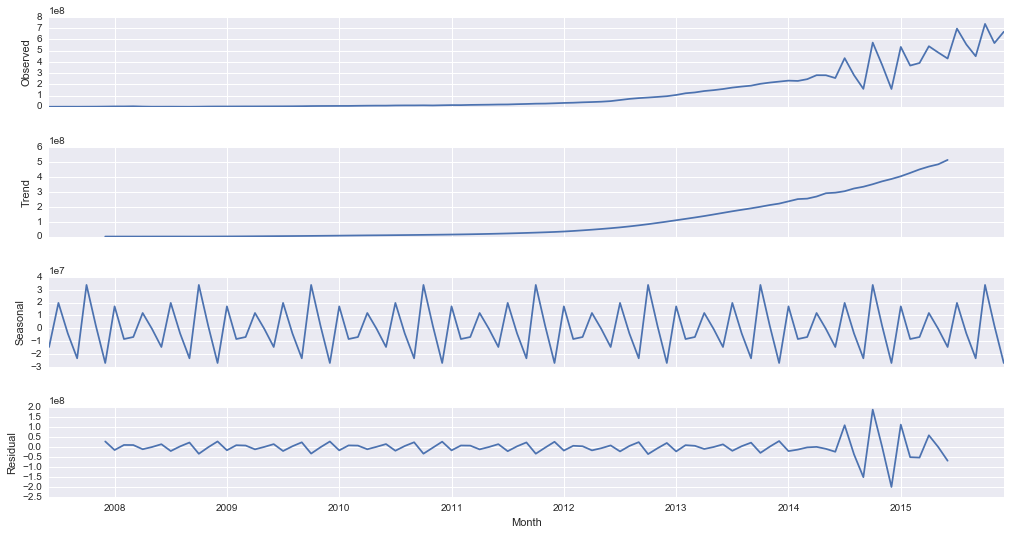

In [8]:
decomposition = seasonal_decompose(loan_df['Funded_Amnt_Monthly'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

Most of the Timeseries(TS) models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
### Checking for Stationarity in the TS
A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.
For a more accurate assessment we run Dickey-Fuller test from statsmodels package. This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

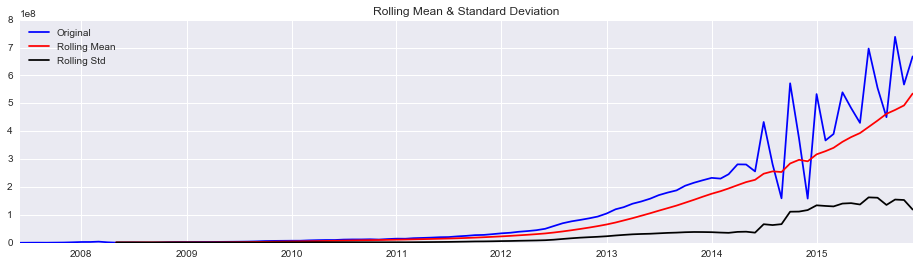

Results of Dickey-Fuller Test:
Test Statistic                  2.262782
p-value                         0.998930
#Lags Used                     12.000000
Number of Observations Used    90.000000
Critical Value (5%)            -2.894232
Critical Value (1%)            -3.505190
Critical Value (10%)           -2.584210
dtype: float64


In [10]:
test_stationarity(loan_df['Funded_Amnt_Monthly'])

Clearly the variation in standard deviation pretty large in the last few months, mean is clearly increasing with time. Also, the test statistic is way more than the critical values. We can easily see that the time series is not stationary, and our test_stationarity function confirms that.
In order to further analyze the data, we have to make the series Stationarity. In general there are two components to it.
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of loans was growing over time
2. Seasonality - variations at specific time-frames. eg people might have a tendency to bowwor more in a particular month because of seasonal issues or festivals

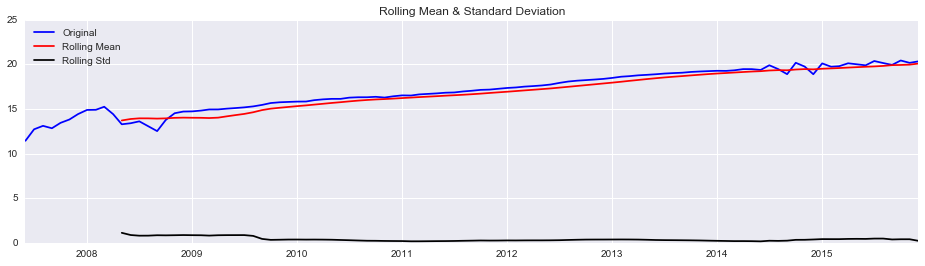

Results of Dickey-Fuller Test:
Test Statistic                 -2.201031
p-value                         0.205871
#Lags Used                     13.000000
Number of Observations Used    89.000000
Critical Value (5%)            -2.894607
Critical Value (1%)            -3.506057
Critical Value (10%)           -2.584410
dtype: float64


In [11]:
loan_df['Funded_Amnt_Monthly_log']= loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x))  
test_stationarity(loan_df['Funded_Amnt_Monthly_log'])

Log Transformation of the series did helped, but still the series is not stationary. We can do first differencing, and then first log differencing to bring the series to stationarity.

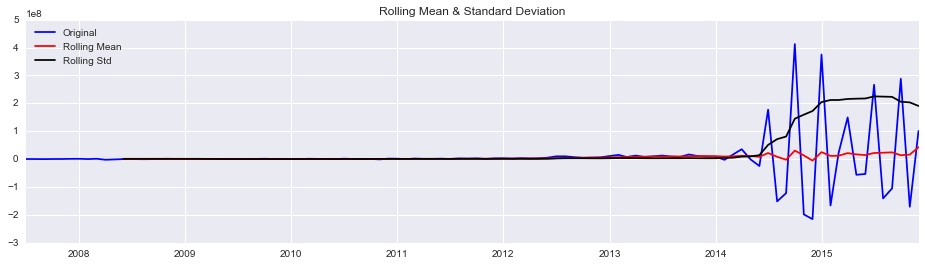

Results of Dickey-Fuller Test:
Test Statistic                  3.678051
p-value                         1.000000
#Lags Used                     13.000000
Number of Observations Used    88.000000
Critical Value (5%)            -2.894990
Critical Value (1%)            -3.506944
Critical Value (10%)           -2.584615
dtype: float64


In [12]:
loan_df['Funded_Amnt_Monthly_1stDiff'] = loan_df['Funded_Amnt_Monthly'] - loan_df['Funded_Amnt_Monthly'].shift(1)  
test_stationarity(loan_df['Funded_Amnt_Monthly_1stDiff'].dropna(inplace=False))

As can be seen above, the first differencing did not yield stationarity to the data. Next step is to do first differencing of the log of the series.

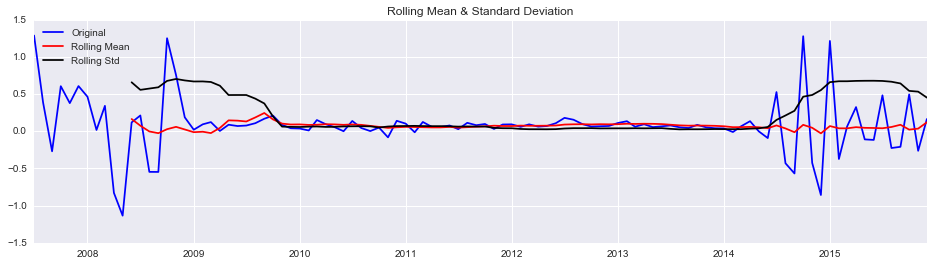

Results of Dickey-Fuller Test:
Test Statistic                 -4.550885
p-value                         0.000159
#Lags Used                     13.000000
Number of Observations Used    88.000000
Critical Value (5%)            -2.894990
Critical Value (1%)            -3.506944
Critical Value (10%)           -2.584615
dtype: float64


In [13]:
loan_df['Funded_Amnt_Monthly_log_1stDiff'] = loan_df['Funded_Amnt_Monthly_log'] - loan_df['Funded_Amnt_Monthly_log'].shift(1)  
test_stationarity(loan_df['Funded_Amnt_Monthly_log_1stDiff'].dropna(inplace=False))

As can be seen by the p-value, difference has now made our data stationary. We also looked at doing double log, double differencing etc, but it didn’t make the data any more stationary

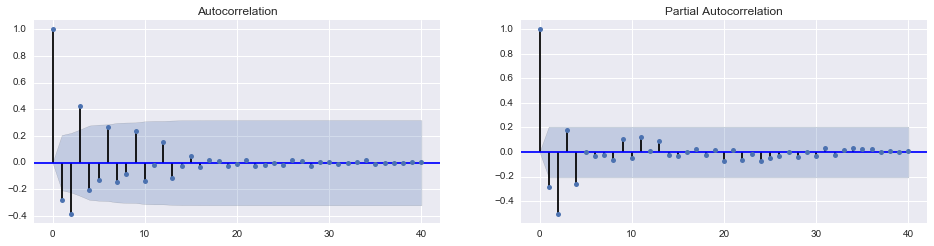

In [14]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(loan_df['Funded_Amnt_Monthly_log_1stDiff'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(loan_df['Funded_Amnt_Monthly_log_1stDiff'].iloc[13:], lags=40, ax=ax2)

Some rules to follow:

Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.


In this case, we have PACF goes negative. We check different AR/MA values, but AR = p= 0 and and ACF the lag-1 autocorrelation is negative hence we take q = 2 seems to be a good choice so far, and we already know that we should take single differencing i.e. d= 1.

In [15]:
loan_df['Funded_Amnt_Monthly_log_1stDiff'] = loan_df['Funded_Amnt_Monthly_log_1stDiff'].fillna(0)

In [16]:
mod = sm.tsa.ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(0,1,2))
results_AR = mod.fit()
print results_AR.summary()

                               ARIMA Model Results                               
Dep. Variable:     D.Funded_Amnt_Monthly   No. Observations:                  102
Model:                    ARIMA(0, 1, 2)   Log Likelihood                 -32.429
Method:                          css-mle   S.D. of innovations              0.331
Date:                   Sat, 09 Jul 2016   AIC                             72.857
Time:                           23:31:10   BIC                             83.357
Sample:                       07-01-2007   HQIC                            77.109
                            - 12-01-2015                                         
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const                           0.0810      0.021      3.885      0.000         0.040     0.122
ma.L1.D.Funded_Amnt_Monthly     0.1530      0.106      1

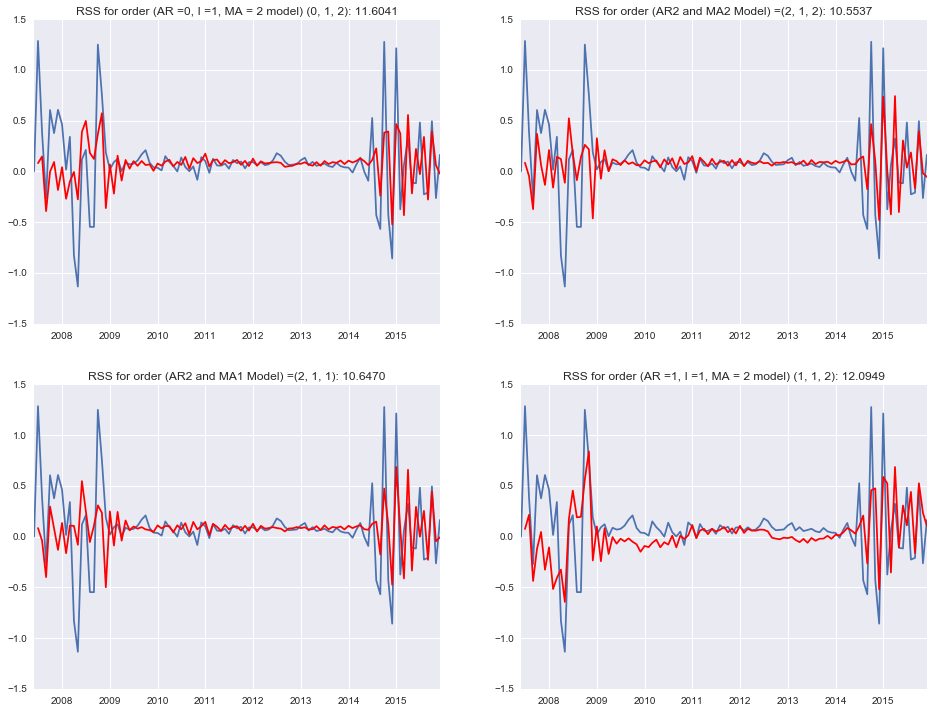

In [17]:
from matplotlib.pyplot import *
fig = plt.figure(figsize=(16,12))

subplot(221)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(0, 1, 2))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR =0, I =1, MA = 2 model) (0, 1, 2): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))

subplot(222)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(2, 1, 2))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR2 and MA2 Model) =(2, 1, 2): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))

subplot(223)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(2, 1, 1))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR2 and MA1 Model) =(2, 1, 1): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))


subplot(224)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(1, 1, 2))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR =1, I =1, MA = 2 model) (1, 1, 2): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))



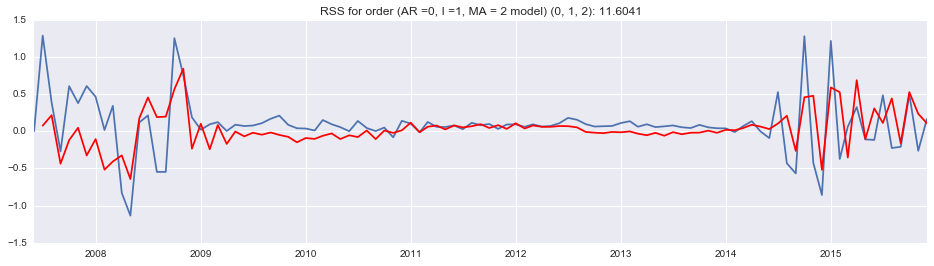

In [18]:
fig = plt.figure(figsize=(16,4))
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(0, 1, 2))
results_AR_final = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR =0, I =1, MA = 2 model) (0, 1, 2): %.4f'% sum((results_AR_final.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))

### Forecasting the funds required to continue the growth trend
Our next step is to estimate the amount of funds needed to facilitate the loans at the same rate and continue at the growth path. By understanding the amount of funds needed the company can be better prepared to overcome any obstacles in timely manner. 
Additionally, by doing the similar analysis and checking the amount of incoming money (Interest + Payments made by borrowers), company can plan the financial debt more accurately.

In [19]:
predictions_ARIMA_diff = pd.Series(results_AR_final.fittedvalues, copy=True)
print predictions_ARIMA_diff.tail()

Month
2015-08-01    0.339629
2015-09-01   -0.278037
2015-10-01    0.393455
2015-11-01    0.060029
2015-12-01   -0.022363
dtype: float64


In [20]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.tail()

Month
2015-08-01    7.626499
2015-09-01    7.348463
2015-10-01    7.741918
2015-11-01    7.801947
2015-12-01    7.779584
dtype: float64


In [21]:
predictions_ARIMA_log = pd.Series(loan_df['Funded_Amnt_Monthly_log'].ix[0], index=loan_df['Funded_Amnt_Monthly_log'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

Month
2015-08-01    19.054411
2015-09-01    18.776375
2015-10-01    19.169830
2015-11-01    19.229859
2015-12-01    19.207496
dtype: float64

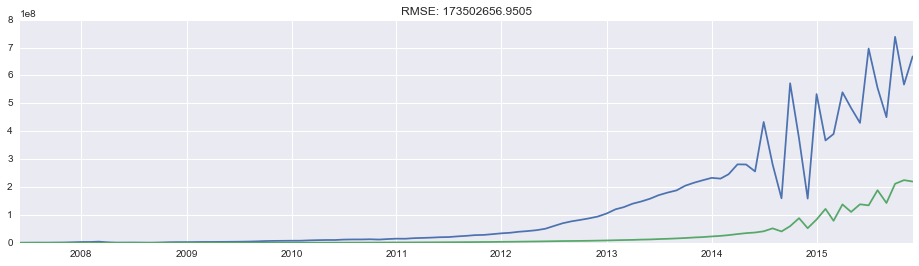

In [22]:
fig = plt.figure(figsize=(16,4))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(loan_df['Funded_Amnt_Monthly'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-loan_df['Funded_Amnt_Monthly'])**2)/len(loan_df)))
loan_df['Prediction_ARIMA'] = predictions_ARIMA

In [23]:
start = datetime.datetime.strptime("2015-12-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= loan_df.columns)
loan_df = pd.concat([loan_df, future])

In [24]:
loan_df['forecast_final_log'] = results_AR.predict(start = loan_df_shape_old, end = loan_df.shape[0], dynamic= True)
loan_df['forecast_final_cumsum'] = loan_df['forecast_final_log'].cumsum()
loan_df['forecast_final_Running_cumsum'] = predictions_ARIMA_log.ix[-1] + loan_df['forecast_final_log'].cumsum()
loan_df['forecast_final'] = np.exp(loan_df['forecast_final_Running_cumsum'])

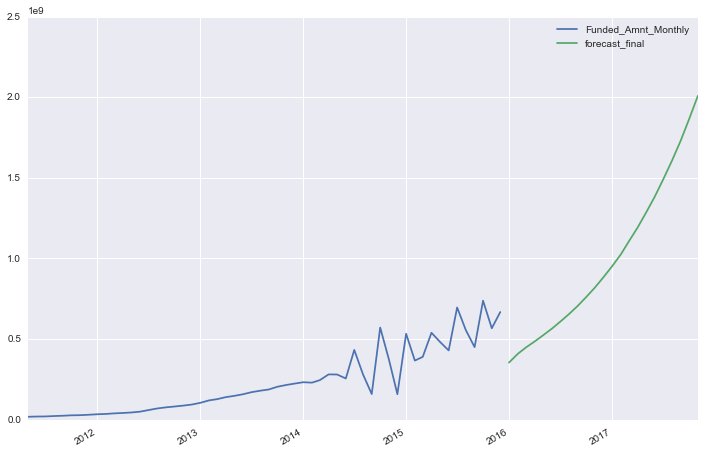

In [25]:
loan_df[['Funded_Amnt_Monthly', 'forecast_final']].ix[-80:].plot(figsize=(12, 8))

As we can see above, the exponential trend in the original series makes the accuracy of the final prediction a very difficult task. But even if we go with this result (which starts from lower values, but rises exponentially), we can see that the company needs a lot of money very soon, in order to grow at the similar rate.

### Concluding Remarks:
In order for the company to survive and grow further, there are many challenges that needs to be addressed.
1. The Incoming Payments have reduced, this is an alarming sign and the company should put every effort to build a system to predict and proactively preempt the defaulters or late payers
2. In order for company to grow at the same rate, they will have to generate cash and collect the payments at a much faster rate
3. As more loans are issued recently, the amount received should start increasing in next few month. That is very important for the company to survive and grow.
4. At this rate the company would need cash flow of ~2 BUSD by 2017 from Banks, Payments received and Investors on monthly basis